Query on Cosmohub to get Gaia EDR3 data:

    SELECT `solution_id`, `designation`, `source_id`, `ra`, `ra_error`, `dec`, `dec_error`, `parallax`, `parallax_error`, `pm`, `pmra`, `pmra_error`, `pmdec`, `pmdec_error`, `ra_dec_corr`, `ra_parallax_corr`, `ra_pmra_corr`, `ra_pmdec_corr`, `dec_parallax_corr`, `dec_pmra_corr`, `dec_pmdec_corr`, `parallax_pmra_corr`, `parallax_pmdec_corr`, `pmra_pmdec_corr`, `visibility_periods_used`, `astrometric_sigma5d_max`, `ruwe`, `duplicated_source`, `phot_g_mean_flux`, `phot_g_mean_flux_error`, `phot_g_mean_flux_over_error`, `phot_g_mean_mag`, `phot_bp_mean_flux`, `phot_bp_mean_flux_error`, `phot_bp_mean_flux_over_error`, `phot_bp_mean_mag`, `phot_rp_mean_flux`, `phot_rp_mean_flux_error`, `phot_rp_mean_flux_over_error`, `phot_rp_mean_mag`, `dr2_radial_velocity`, `dr2_radial_velocity_error`, `l`, `b`, `phot_bp_rp_excess_factor` FROM gaia_edr3 WHERE `phot_g_mean_mag` < 18.5 AND (`b` > 30 OR `b` < -30)
    
    
Validation plots:
- Sky density in bins of magnitude (healpix)
- xy plane density

In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from pyia import GaiaData

In [2]:
allg = GaiaData('/mnt/home/apricewhelan/data/GaiaEDR3/Gaia-b30-G18.5.fits')

In [11]:
G_max = 18.5 * u.mag
b_max = 30 * u.deg

mask = (allg.parallax > 1 * u.mas) & ((allg.parallax / allg.parallax_error) > 5)
g = allg[mask]

len(g), len(allg), (allg.ruwe < 1.4).sum() / len(allg), mask.sum() / len(allg)

(12621978, 37766503, 0.9325565303200034, 0.33421092760428467)

In [12]:
# Raw photometry
# MG = g.phot_g_mean_mag - g.distmod
# BPRP = g.bp_rp

# attempt at extinction-correcting the photometry:
MG = g.get_G0() - g.distmod
BPRP = g.get_BP0() - g.get_RP0()

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:33: RuntimeWarning: overflow encountered in multiply
  AG = F1(curbp)*A0
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:34: RuntimeWarning: overflow encountered in multiply
  Abp = F2(curbp)*A0
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:35: RuntimeWarning: overflow encountered in multiply
  Arp = F3(curbp)*A0
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:36: RuntimeWarning: overflow encountered in add
  curbp1 = bp-rp-Abp+Arp
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


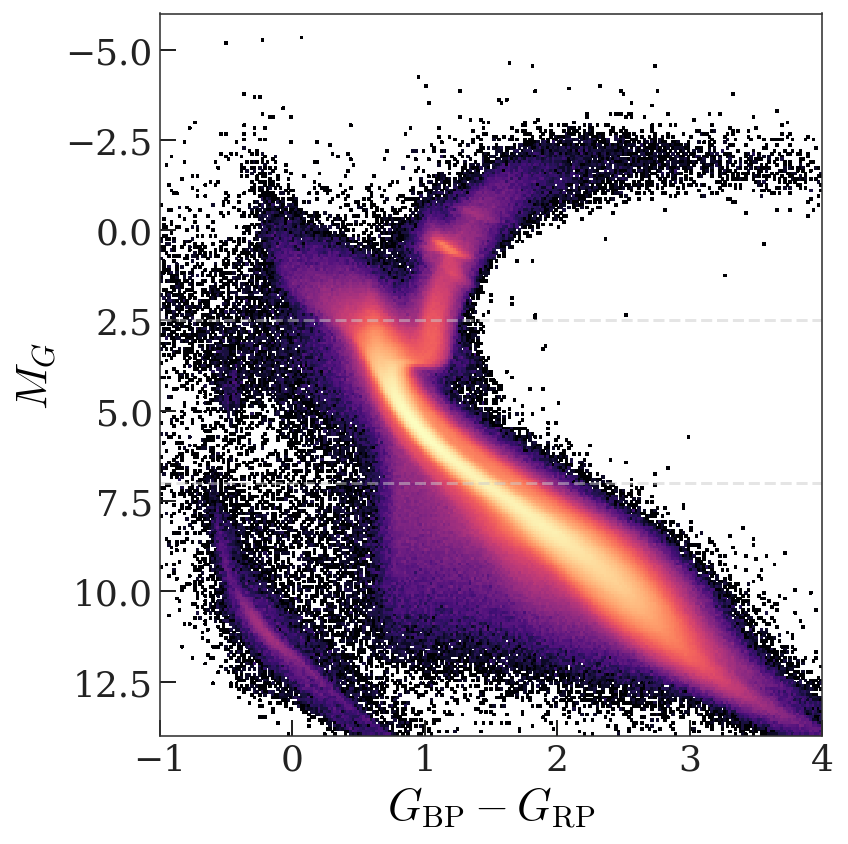

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

bins = (np.linspace(-1, 4, 256),
        np.linspace(-6, 14, 256))

ax.hist2d(
    BPRP.value, 
    MG.value,
    bins=bins,
    norm=mpl.colors.LogNorm()
)

for lim in MG_lim:
    ax.axhline(lim.value, marker='', color='#cccccc', 
               linestyle='--', alpha=0.5)

ax.set_ylim(14, -6)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')

fig.tight_layout()

Select the upper main sequence (but not too upper, and remove the giant branch). These $M_G$ limits correspond roughly to F-type stars through mid-K stars based on:
https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

In [24]:
MG_lim = [2.5, 7] * u.mag
maxdist = coord.Distance(distmod=G_max - max(MG_lim))
print(f"rough maximum distance for completeness: {maxdist:.0f}")

rough maximum distance for completeness: 2 kpc


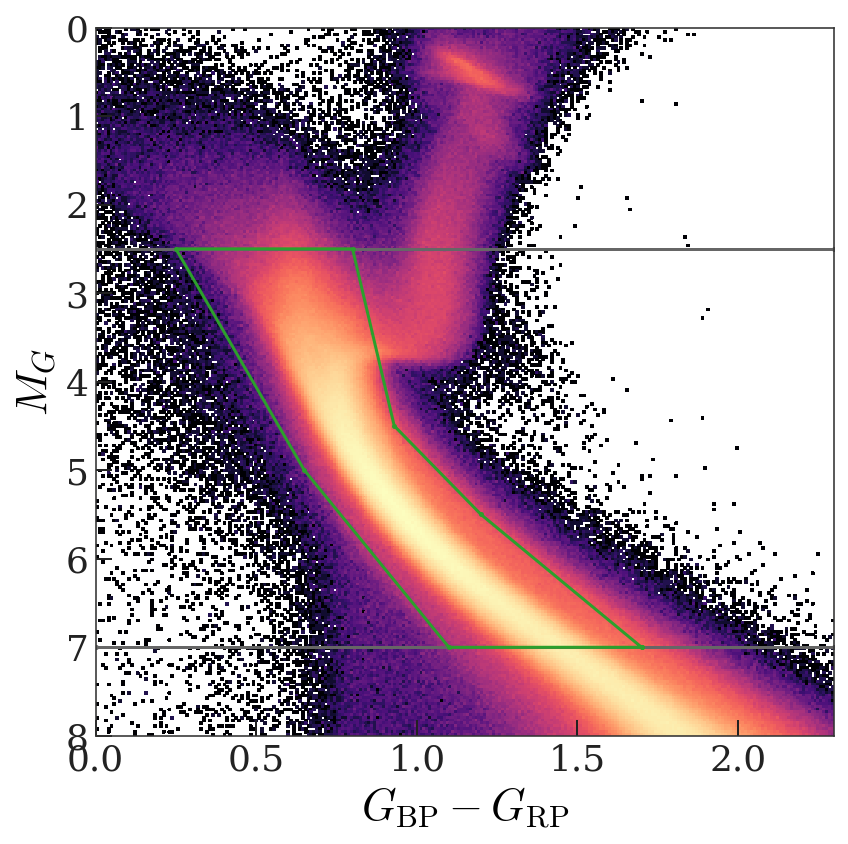

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d(
    BPRP.value, 
    MG.value,
    bins=(np.linspace(0, 2.3, 256),
          np.linspace(0, 8, 256)),
    norm=mpl.colors.LogNorm()
)

for lim in MG_lim:
    ax.axhline(lim.value)
    
nodes = np.array([
    [1.7, 7],
    [1.1, 7],
    [0.65, 5],
    [0.25, 2.5],
    [0.8, 2.5],
    [0.93, 4.5],
    [1.2, 5.5],
    [1.7, 7]
])
ax.plot(nodes[:, 0], nodes[:, 1], color='tab:green')
path_ = mpl.path.Path(nodes)
cmd_mask = path_.contains_points(np.stack((BPRP.value, MG.value)).T)

ax.set_ylim(8, 0)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')
fig.tight_layout()

In [46]:
mask = (
    cmd_mask
)
cmd_mask.sum(), mask.sum()

(4848104, 4848104)

In [47]:
ms_g = g[mask]

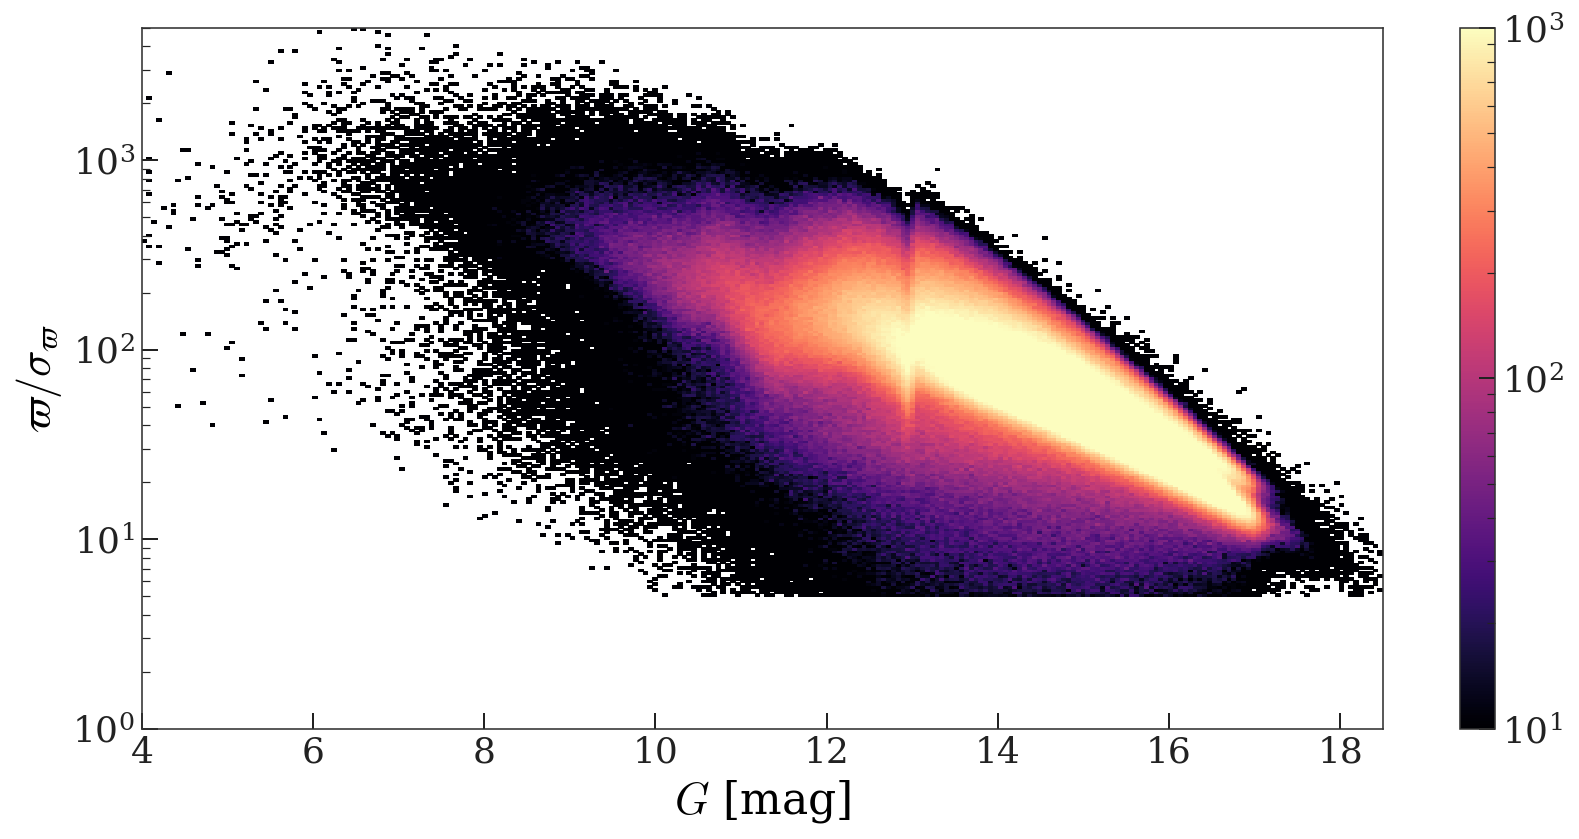

In [187]:
plt.figure(figsize=(12, 6))
plt.hist2d(
    ms_g.phot_g_mean_mag.value, 
    ms_g.parallax.value / ms_g.parallax_error.value,
    bins=(np.linspace(4, 18.5, 256),
          np.geomspace(1, 5e3, 256)),
    norm=mpl.colors.LogNorm(vmin=10, vmax=1e3)
)
plt.colorbar()
plt.yscale('log')
plt.xlabel('$G$ [mag]')
plt.ylabel(r'$\varpi / \sigma_\varpi$')
plt.tight_layout()

In [48]:
gal = ms_g.skycoord.galactic
x, y, z = gal.represent_as('cartesian').xyz.to_value(u.kpc)

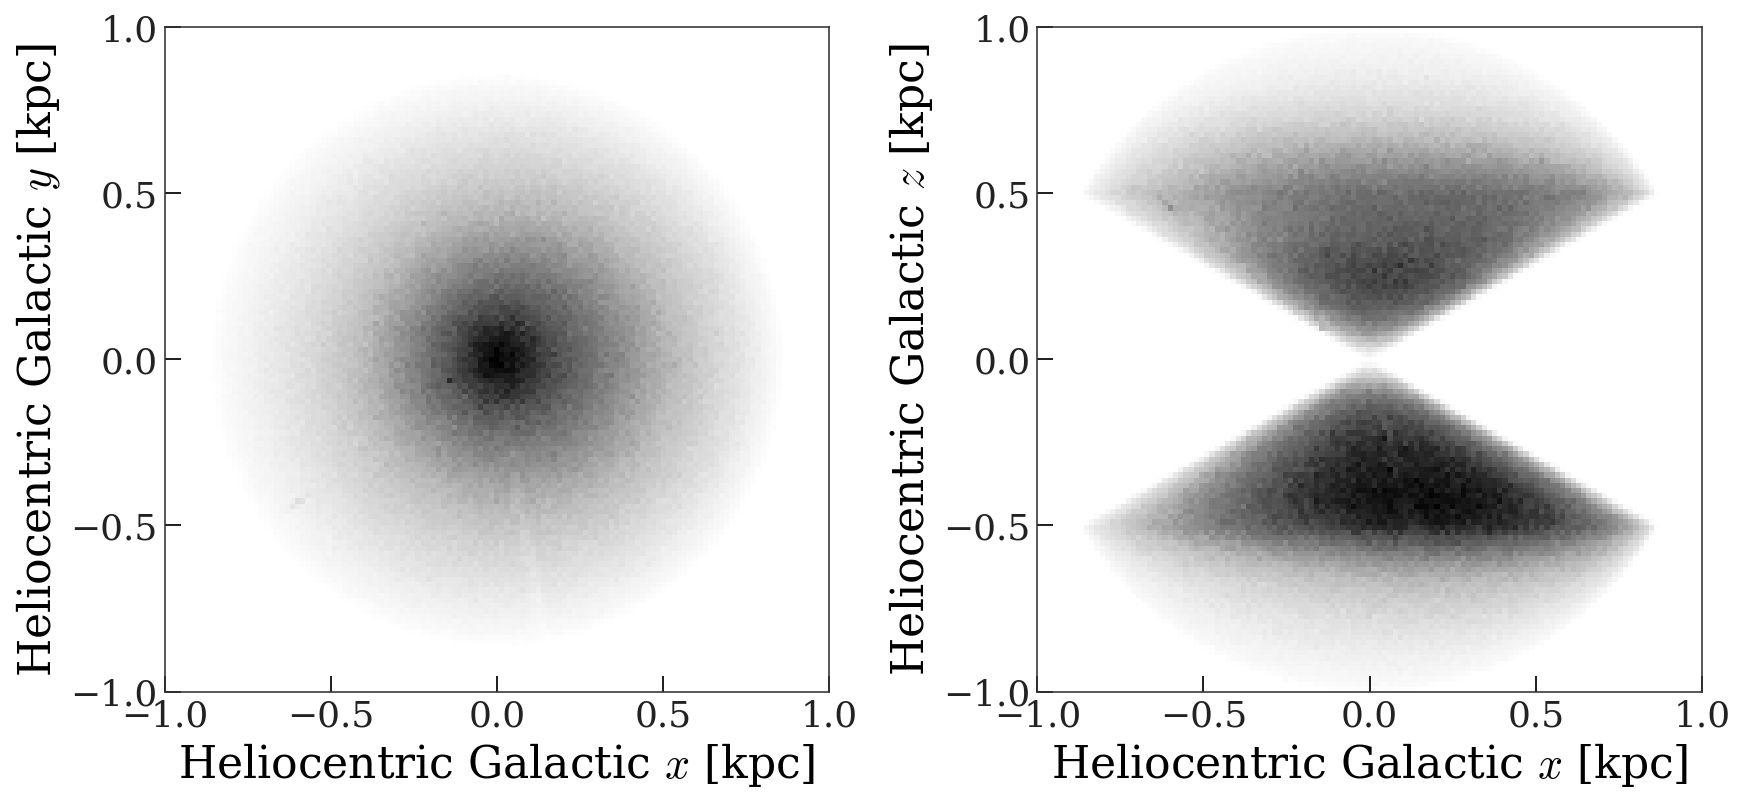

In [196]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-1, 1)
for ax, coords, labels in zip(axes, 
                              [(x, y), (x, z)], 
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=maxdist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );

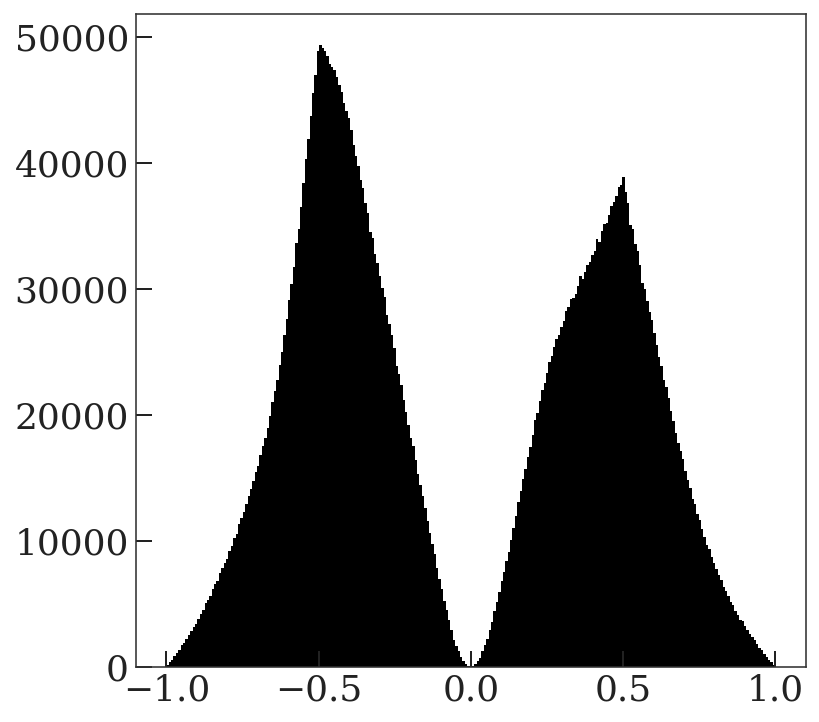

In [171]:
plt.hist(z, bins=np.linspace(-1, 1, 256));
# plt.yscale('log')

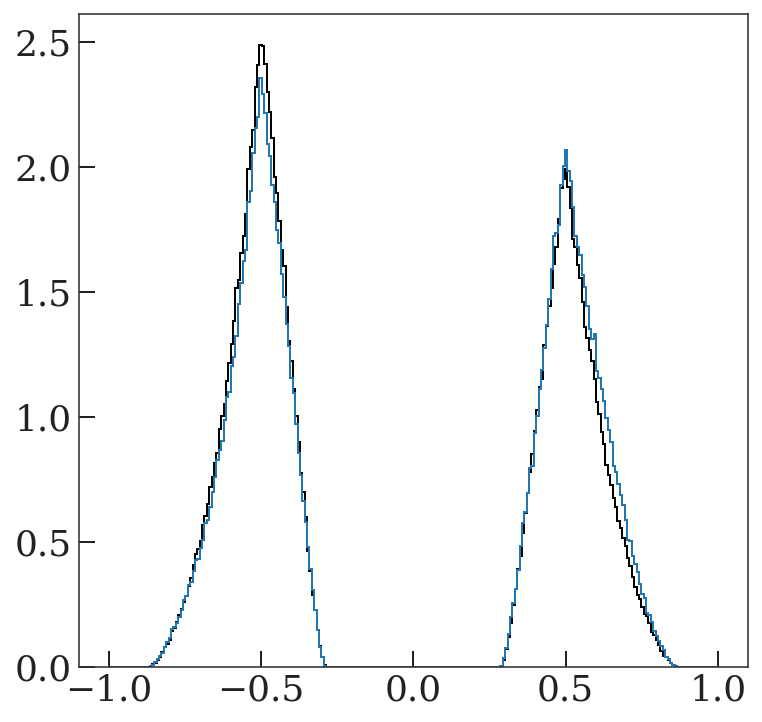

In [205]:
kw = dict(bins=np.linspace(-1, 1, 256), density=True, histtype='step')
plt.hist(z[x > 0.5], **kw)
plt.hist(z[x < -0.5], **kw);
# plt.yscale('log')

In [110]:
def density(xyz, rho0, h1, h2, f):
    z = xyz[2]
    return rho0 * (f * np.cosh(z / (2 * h1))**-2 + (1-f) * np.cosh(z / (2 * h2))**-2) * np.exp()

In [111]:
N = 1024
xyz = np.stack((
    np.zeros(N), 
    np.zeros(N), 
    np.linspace(-1, 1, N)
)) * u.kpc

with u.set_enabled_equivalencies(u.dimensionless_angles()):
    rho = density(xyz, 1*u.Msun/u.pc**3, h1=200*u.pc, h2=800*u.pc, f=0.3)

(-2.0, 2.0)

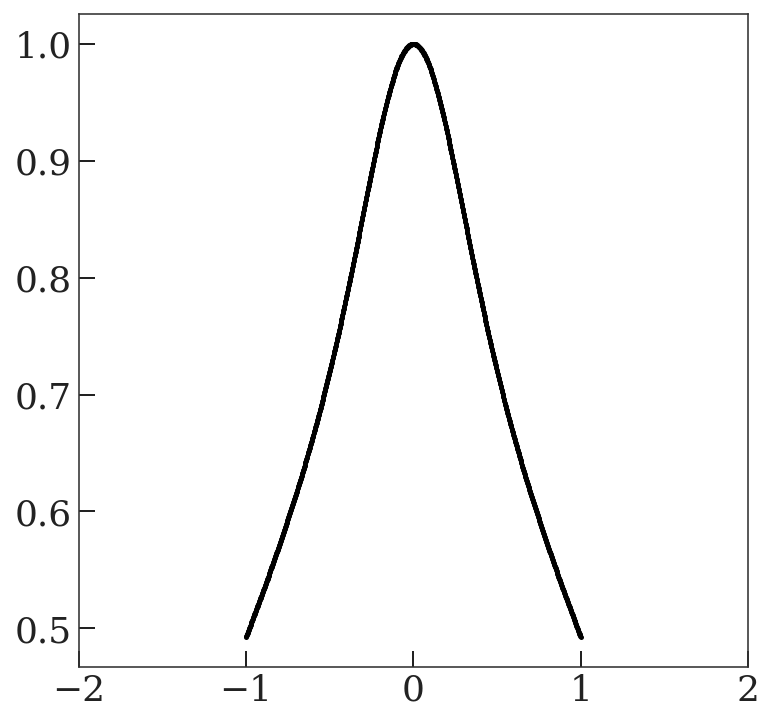

In [112]:
plt.plot(xyz[2], rho.value)
plt.xlim(-2., 2.)

Inverse transform sampling to generate "true" z values for simulation:

In [144]:
def invt_sample_z(density, size=1, args=(), lim=[-1, 1]*u.kpc, 
                  growth_factor=4, rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
    
    ymax = density([0,0,0]*u.pc, *args)
    ymin = u.Quantity([
        density([0,0,lim[0]], *args),
        density([0,0,lim[1]], *args)
    ]).min().to(ymax.unit)
    
    samples = []
    batch_size = 16 * size  # MAGIC NUMBER
    MAXITER = 128  # MAGIC NUMBER
    iter_ = 0
    while len(samples) < size and iter_ < MAXITER:
        trial = np.zeros((3, batch_size)) * lim.unit
        trial[2] = rng.uniform(*lim.value, size=batch_size) * lim.unit
        
        ytrial = rng.uniform(ymin.value, ymax.value, size=batch_size) * ymin.unit
        
        mask = ytrial < density(trial, *args)
        if len(samples) == 0 and mask.sum() > 0:
            samples = trial[:, mask]
        else:
            samples = np.hstack((samples, trial[:, mask]))
        
        batch_size *= growth_factor
        iter_ += 1
        
        if samples.shape[1] > size:
            break
            
    return samples[2, :size]

In [188]:
rng = np.random.default_rng(seed=42)
args = (1*u.Msun/u.pc**3, 200*u.pc, 800*u.pc, 0.3)

N = 10_000_000
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    z_samples = invt_sample_z(density, size=N, args=args, rng=rng)
    
xy_samples = rng.uniform(-1, 1, size=(2, N)) * u.kpc
xyz_samples = np.vstack((xy_samples, z_samples))

In [189]:
sim_rep = coord.CartesianRepresentation(
    xyz_samples - ([0, 0, 20.8] * u.pc)[:, None]
)
sim_c = coord.SkyCoord(sim_rep, frame='galactic')
sim_mask = (
    (sim_c.distance.parallax > 1*u.mas) &
    (np.abs(sim_c.b) > 30*u.deg)
)

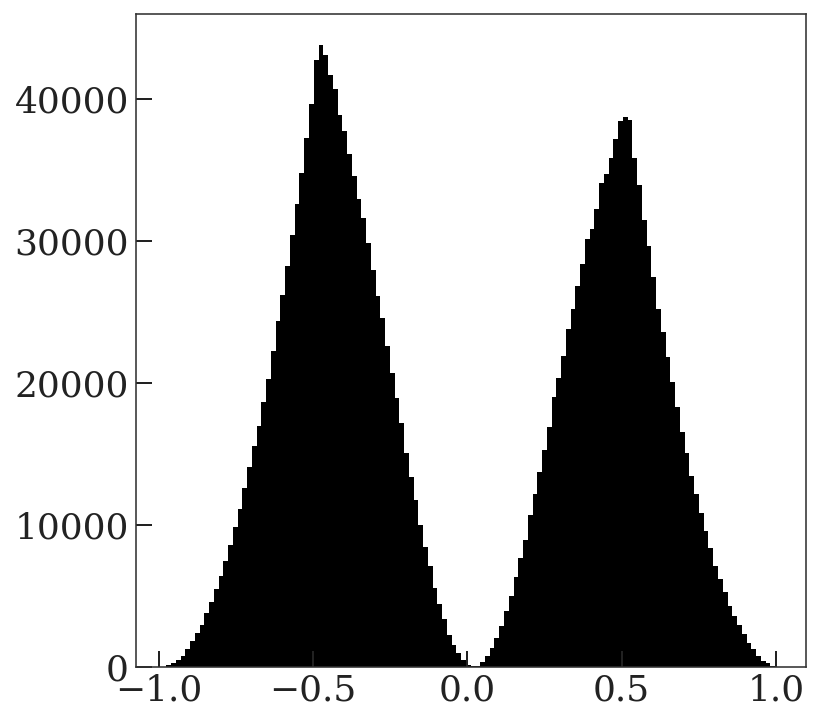

In [190]:
plt.hist(z_samples.value[sim_mask], bins=128);

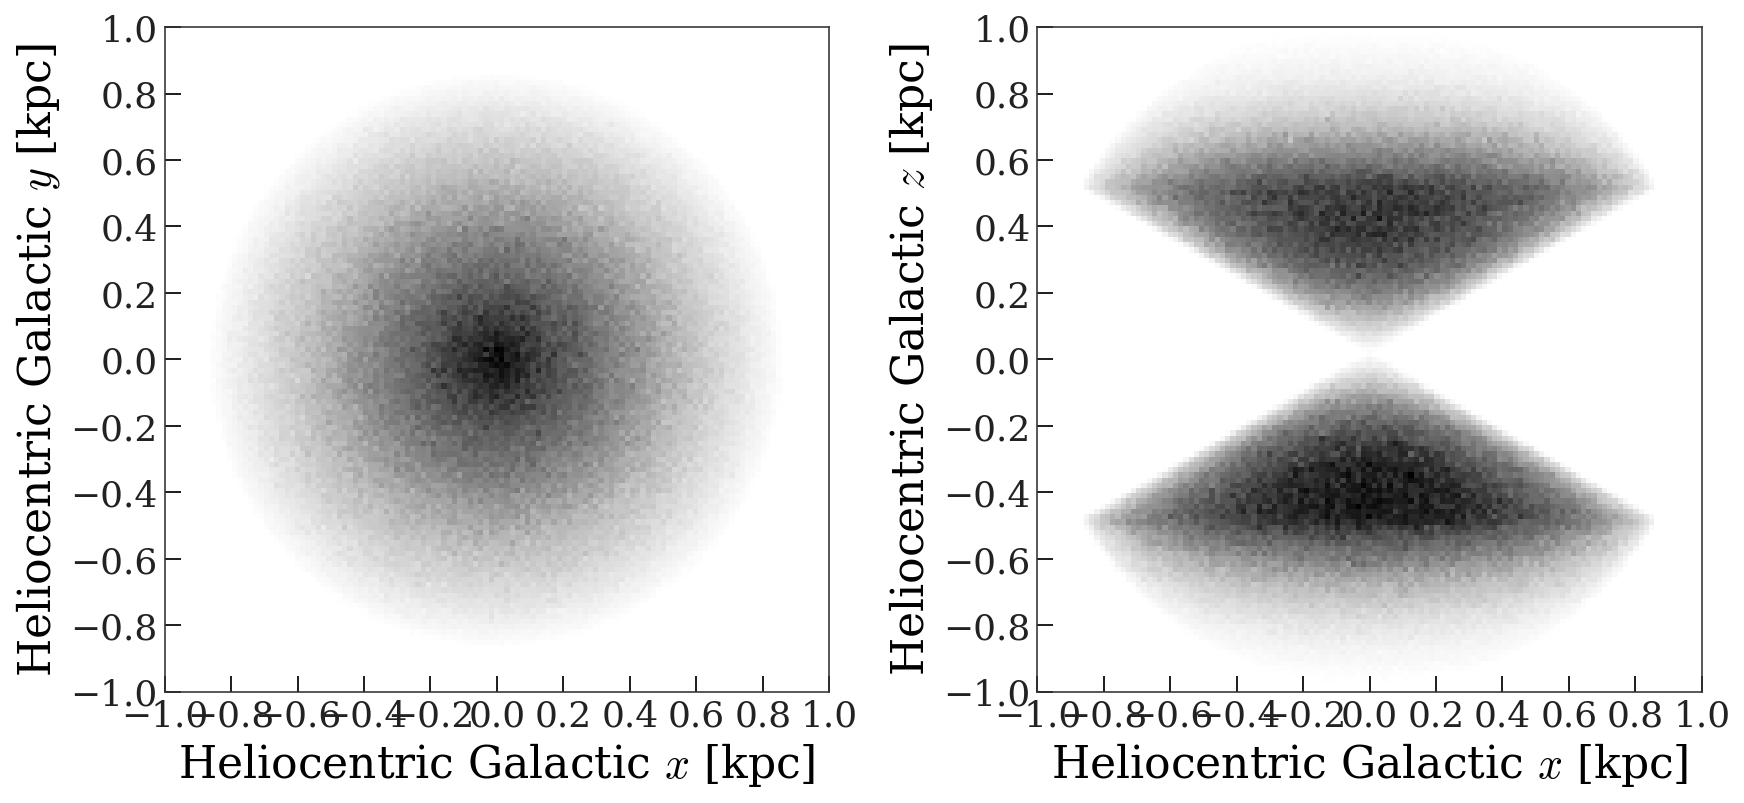

In [195]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-1, 1)
for ax, coords, labels in zip(axes, 
                              [(xyz_samples[0, sim_mask].value, 
                                xyz_samples[1, sim_mask].value), 
                               (xyz_samples[0, sim_mask].value, 
                                xyz_samples[2, sim_mask].value)], 
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=maxdist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.2),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.2)
    );

In [68]:
from astropy.coordinates.matrix_utilities import (
    rotation_matrix,
    matrix_product
)


def get_M(sgrAs, zsun, roll):
    # rotation matrix to align x(ICRS) with the vector to the Galactic center
    mat1 = rotation_matrix(-sgrAs.dec, 'y')
    mat2 = rotation_matrix(sgrAs.ra, 'z')
    mat0 = rotation_matrix(roll, 'x')

    # construct transformation matrix and use it
    R = matrix_product(mat0, mat1, mat2)

    # Now need to translate by Sun-Galactic center distance around x' and
    # rotate about y' to account for tilt due to Sun's height above the plane
    z_d = zsun / sgrAs.distance
    H = rotation_matrix(-np.arcsin(z_d), 'y')

    # compute total matrices
    A = matrix_product(H, R)

    return A

In [73]:
# For consistency with galactocentric:
sgrA = coord.SkyCoord(
    266.4051 * u.deg,
    -28.936175 * u.deg,
    distance=8.275 * u.kpc
)
M = get_M(sgrA, zsun=20 * u.pc, roll=58.6 * u.deg)
M

array([[-0.0569709 , -0.87391334, -0.48273158],
       [ 0.49409005, -0.44483335,  0.74699285],
       [-0.86754213, -0.19595602,  0.45713444]])

In [77]:
c1 = coord.SkyCoord(0, 89, unit=u.deg, frame='galactic').icrs
c1.data.to_cartesian().transform(M)

<CartesianRepresentation (x, y, z) [dimensionless]
    (0.01986747, 2.23870795e-05, 0.99980262)>

Parameters:
- $z_\odot$
- orientation of the galactic plane

These cartesian coordinates are a rotation $\mathbf{M}$ away from the ICRS cartesian coordinates
$$
\textbf{x} = (x, y, z) = \mathbf{M}\,\textbf{x}_{\textrm{ICRS}}
$$
where one angle in the rotation matrix is set by the (fixed) sky position of the Galactic center, one is set by the Sun's height above the midplane and distance to the Galactic center, and one is set by the orientation of the Galactic plane (on the sky?) or position angle or "roll" or whatever.

In the rotated "Galactocentric" coordinates $\textbf{x}$:
$$
\rho(\textbf{x}) = \rho_0 \, \left[
    \textrm{sech}^2\left(\frac{z + z_\odot}{2\,h_1}\right) + 
    \alpha \, \textrm{sech}^2\left(\frac{z + z_\odot}{2\,h_2}\right)
    \right]
$$
where the density is assumed to be uniform in $x, y$ and only depend on $z$.